# Summary:
This notebook will cover applying **Question Answering (QA)** using **BERT** for tweet sentiment extraction.

# Table of contents
* [1. Data preparation](#Part1_link)
<br >&nbsp;&nbsp;&nbsp;[1.1 Create examples and features for input data](#Part1.1_link)
<br >&nbsp;&nbsp;&nbsp;[1.2 Generate data input for BERT](#Part1.2_link)
<br >&nbsp;&nbsp;&nbsp;[1.3 Generate TensorDataset and DataLoader](#Part1.3_link)
* [2. Train the Question Answering model](#Part2_link)
<br >&nbsp;&nbsp;&nbsp;[2.1 Model training](#Part2.1_link)
<br >&nbsp;&nbsp;&nbsp;[2.2 Evaluate training performance](#Part2.2_link)
* [3. Model evaluation](#Part3_link)
<br >&nbsp;&nbsp;&nbsp;[3.1 Predict extracted text using trained model for training datasets](#Part3.1_link)
<br >&nbsp;&nbsp;&nbsp;[3.2 Compute jaccard similarity score for predictions on training datasets](#Part3.2_link)
* [4. Prediction on test datasets](#Part4_link)

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from nltk import sent_tokenize
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import transformers
from transformers import BertTokenizer
from transformers import BertModel
from transformers import BertForQuestionAnswering
from transformers.tokenization_bert import BasicTokenizer
from sklearn.model_selection import train_test_split
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import collections
import math
from tqdm import tqdm

In [2]:
base_dir="/Volumes/Yuchen_Drive/Tweet_Sentiment_Extraction/tweet-sentiment-extraction"

In [3]:
train_df=pd.read_csv(os.path.join(base_dir,"train.csv"))
test_df=pd.read_csv(os.path.join(base_dir,"test.csv"))
print("training set: {}".format(train_df.shape))
print("testing set: {}".format(test_df.shape))
train_df.dropna(inplace=True)
print("training set after removing NA: {}".format(train_df.shape))

training set: (27481, 4)
testing set: (3534, 3)
training set after removing NA: (27480, 4)


In [4]:
train_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [5]:
test_df.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


<a id='Part1_link'></a>
# 1. Data preparation

<a id='Part1.1_link'></a>
## 1.1 Create examples and features for input data

In [6]:
tokenizer=BertTokenizer.from_pretrained("bert-base-uncased",do_lower_case=True)

In [7]:
class SquadExample(object):
    """
    A single training/test example for the Squad dataset.
    For examples without an answer, the start and end position are -1.
    """

    def __init__(self,example_id,question_text,context_text,ans_text,doc_tokens,start_position,end_position,unique_id):
        self.example_id = example_id
        self.question_text = question_text
        self.context_text = context_text
        self.ans_text=ans_text
        self.doc_tokens = doc_tokens
        self.start_position=start_position
        self.end_position=end_position
        self.unique_id = unique_id

    def __str__(self):
        return self.__repr__()

    def __repr__(self):
        s = ""
        s += ", question_text: %s" % (self.question_text)
        s += ", doc_tokens: [%s]" % (" ".join(self.doc_tokens))
        
        return s

In [8]:
def read_paragraphs(data_df,is_training=True):
    '''
    Convert input to tokens and returns example object
    '''    
    def is_whitespace(c):
        if c == " " or c == "\t" or c == "\r" or c == "\n" or ord(c) == 0x202F:
            return True
        return False
    i = 0
    examples = []
    for idx,entry in data_df.iterrows():
        context_text=entry["text"]
        if is_training:
            ans_text=entry["selected_text"]
            start_position_character=context_text.find(ans_text)
        else:
            ans_text=None
        doc_tokens = []
        char_to_word_offset = []
        prev_is_whitespace = True
        for c in context_text:
            if is_whitespace(c):
                prev_is_whitespace = True
            else:
                if prev_is_whitespace:
                    doc_tokens.append(c)
                else:
                    doc_tokens[-1] += c
                prev_is_whitespace = False
            char_to_word_offset.append(len(doc_tokens) - 1)
        if is_training:
            start_position = char_to_word_offset[start_position_character]
            end_position=char_to_word_offset[min(start_position_character+len(ans_text)-1, len(char_to_word_offset)-1)]
        else:
            start_position=0
            end_position=0
        example = SquadExample(example_id=entry["textID"],              
                               question_text=entry["sentiment"],
                               context_text=entry["text"],
                               ans_text=ans_text,
                               doc_tokens=doc_tokens,
                               start_position=start_position,
                               end_position=end_position,
                               unique_id = i)
        i+=1
        examples.append(example)

    return examples

In [9]:
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self,
                 input_ids,
                 attention_mask,
                 token_type_ids,
                 start_position,
                 end_position,
                 tokens,
                 token_is_max_context,
                 token_to_orig_map,
                 unique_id,
                 example_index):
 
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.token_type_ids=token_type_ids
        self.start_position=start_position
        self.end_position=end_position
        self.tokens = tokens
        self.token_is_max_context = token_is_max_context
        self.token_to_orig_map = token_to_orig_map
        self.unique_id = unique_id
        self.example_index = example_index

In [10]:
def _improve_answer_span(doc_tokens, input_start, input_end, tokenizer, orig_answer_text):
    """Returns tokenized answer spans that better match the annotated answer."""
    tok_answer_text = " ".join(tokenizer.tokenize(orig_answer_text))

    for new_start in range(input_start, input_end + 1):
        for new_end in range(input_end, new_start - 1, -1):
            text_span = " ".join(doc_tokens[new_start : (new_end + 1)])
            if text_span == tok_answer_text:
                return (new_start, new_end)

    return (input_start, input_end)

In [11]:
def _new_check_is_max_context(doc_spans, cur_span_index, position):
    """Check if this is the 'max context' doc span for the token."""
    # if len(doc_spans) == 1:
    # return True
    best_score = None
    best_span_index = None
    for (span_index, doc_span) in enumerate(doc_spans):
        end = doc_span["start"] + doc_span["length"] - 1
        if position < doc_span["start"]:
            continue
        if position > end:
            continue
        num_left_context = position - doc_span["start"]
        num_right_context = end - position
        score = min(num_left_context, num_right_context) + 0.01 * doc_span["length"]
        if best_score is None or score > best_score:
            best_score = score
            best_span_index = span_index

    return cur_span_index == best_span_index

In [12]:
def convert_examples_to_features(examples,tokenizer,max_seq_length,doc_stride,max_query_length,is_training=True):
    """Loads a data file into a list of `InputBatch`s."""

    features = []
    for (unique_id, example) in enumerate(examples):
        query_tokens = tokenizer.tokenize(example.question_text)
        ### Truncate the query if query length > max_query_length..
        if len(query_tokens) > max_query_length:
            query_tokens = query_tokens[0:max_query_length]

        tok_to_orig_index = []
        orig_to_tok_index = []
        all_doc_tokens = []
        for (i, token) in enumerate(example.doc_tokens):
            orig_to_tok_index.append(len(all_doc_tokens))
            sub_tokens = tokenizer.tokenize(token)
            for sub_token in sub_tokens:
                tok_to_orig_index.append(i)
                all_doc_tokens.append(sub_token)
        
        if is_training:
            tok_start_position = orig_to_tok_index[example.start_position]
            if example.end_position < len(example.doc_tokens) - 1:
                tok_end_position = orig_to_tok_index[example.end_position + 1] - 1
            else:
                tok_end_position = len(all_doc_tokens) - 1
            (tok_start_position, tok_end_position) = _improve_answer_span(
                all_doc_tokens, tok_start_position, tok_end_position, tokenizer, example.ans_text
            )
        
        spans = []
        truncated_query = tokenizer.encode(example.question_text, add_special_tokens=False, max_length=max_query_length)
        sequence_added_tokens = (
        tokenizer.max_len - tokenizer.max_len_single_sentence + 1
        if "roberta" in str(type(tokenizer)) or "camembert" in str(type(tokenizer))
        else tokenizer.max_len - tokenizer.max_len_single_sentence
        )
        sequence_pair_added_tokens = tokenizer.max_len - tokenizer.max_len_sentences_pair
        span_doc_tokens = all_doc_tokens
        while len(spans) * doc_stride < len(all_doc_tokens):
            encoded_dict = tokenizer.encode_plus(truncated_query if tokenizer.padding_side == "right" else span_doc_tokens,
                                                 span_doc_tokens if tokenizer.padding_side == "right" else truncated_query,
                                                 max_length=max_seq_length,
                                                 return_overflowing_tokens=True,
                                                 pad_to_max_length=True,
                                                 stride=max_seq_length - doc_stride - len(truncated_query) - sequence_pair_added_tokens,
                                                 truncation_strategy="only_second" if tokenizer.padding_side == "right" else "only_first",
                                                 return_token_type_ids=True,)
            paragraph_len = min(
            len(all_doc_tokens) - len(spans) * doc_stride,
            max_seq_length - len(truncated_query) - sequence_pair_added_tokens)
            
            if tokenizer.pad_token_id in encoded_dict["input_ids"]:
                if tokenizer.padding_side == "right":
                    non_padded_ids = encoded_dict["input_ids"][: encoded_dict["input_ids"].index(tokenizer.pad_token_id)]
                else:
                    last_padding_id_position = (len(encoded_dict["input_ids"]) - 1 - encoded_dict["input_ids"][::-1].index(tokenizer.pad_token_id))
                    non_padded_ids = encoded_dict["input_ids"][last_padding_id_position + 1 :]

            else:
                non_padded_ids = encoded_dict["input_ids"]
            
            tokens = tokenizer.convert_ids_to_tokens(non_padded_ids)
            token_to_orig_map = {}
            for i in range(paragraph_len):
                index = len(truncated_query) + sequence_added_tokens + i if tokenizer.padding_side == "right" else i
                token_to_orig_map[index] = tok_to_orig_index[len(spans) * doc_stride + i]
            
            encoded_dict["paragraph_len"] = paragraph_len
            encoded_dict["tokens"] = tokens
            encoded_dict["token_to_orig_map"] = token_to_orig_map
            encoded_dict["truncated_query_with_special_tokens_length"] = len(truncated_query) + sequence_added_tokens
            encoded_dict["token_is_max_context"] = {}
            encoded_dict["start"] = len(spans) * doc_stride
            encoded_dict["length"] = paragraph_len
            
            spans.append(encoded_dict)
            
            if "overflowing_tokens" not in encoded_dict:
                break
            span_doc_tokens = encoded_dict["overflowing_tokens"]
        
        for doc_span_index in range(len(spans)):
            for j in range(spans[doc_span_index]["paragraph_len"]):
                is_max_context = _new_check_is_max_context(spans, doc_span_index, doc_span_index * doc_stride + j)
                index = (
                    j
                    if tokenizer.padding_side == "left"
                    else spans[doc_span_index]["truncated_query_with_special_tokens_length"] + j
                )
                spans[doc_span_index]["token_is_max_context"][index] = is_max_context
        
        for span in spans:
            cls_index = span["input_ids"].index(tokenizer.cls_token_id)
            p_mask = np.ones_like(span["token_type_ids"])
            if tokenizer.padding_side == "right":
                p_mask[len(truncated_query) + sequence_added_tokens :] = 0
            else:
                p_mask[-len(span["tokens"]) : -(len(truncated_query) + sequence_added_tokens)] = 0
            
            pad_token_indices = np.where(span["input_ids"] == tokenizer.pad_token_id)
            special_token_indices = np.asarray(
                tokenizer.get_special_tokens_mask(span["input_ids"], already_has_special_tokens=True)
            ).nonzero()
            
            p_mask[pad_token_indices] = 1
            p_mask[special_token_indices] = 1
            
            p_mask[cls_index] = 0
            start_position = 0
            end_position = 0
            if is_training:
                doc_start = span["start"]
                doc_end = span["start"] + span["length"] - 1
                out_of_span = False
                
                if not (tok_start_position >= doc_start and tok_end_position <= doc_end):
                    out_of_span = True
            
                if out_of_span:
                    start_position = cls_index
                    end_position = cls_index
                    span_is_impossible = True
                else:
                    if tokenizer.padding_side == "left":
                        doc_offset = 0
                    else:
                        doc_offset = len(truncated_query) + sequence_added_tokens
                
                    start_position = tok_start_position - doc_start + doc_offset
                    end_position = tok_end_position - doc_start + doc_offset
        
        
            features.append(InputFeatures(input_ids=span["input_ids"],
                                          attention_mask=span["attention_mask"],
                                          token_type_ids=span["token_type_ids"],
                                          start_position=start_position,
                                          end_position=end_position,
                                          tokens=span["tokens"],   
                                          token_is_max_context=span["token_is_max_context"],
                                          token_to_orig_map=span["token_to_orig_map"],
                                          unique_id = unique_id,
                                          example_index = example.example_id))
    
    return features

In [14]:
## Create examples for input data
examples=read_paragraphs(train_df)

In [15]:
print(len(examples))
example=examples[1]

27480


In [16]:
print(example.example_id)
print(example.question_text)
print(example.context_text)
print(example.ans_text)
print(example.doc_tokens)
print(example.start_position)
print(example.end_position)
print(example.unique_id)

549e992a42
negative
 Sooo SAD I will miss you here in San Diego!!!
Sooo SAD
['Sooo', 'SAD', 'I', 'will', 'miss', 'you', 'here', 'in', 'San', 'Diego!!!']
0
1
1


In [17]:
## Create features for input data
features=convert_examples_to_features(examples,tokenizer,max_seq_length=128,doc_stride=1,max_query_length=10,is_training=True)


In [18]:
feature=features[1]

In [19]:
print(feature.input_ids)
print(feature.attention_mask)
print(feature.token_type_ids)
print(feature.start_position)
print(feature.end_position)
print(feature.tokens)
print(feature.token_is_max_context)
print(feature.token_to_orig_map)
print(feature.unique_id)
print(feature.example_index)

[101, 4997, 102, 17111, 2080, 6517, 1045, 2097, 3335, 2017, 2182, 1999, 2624, 5277, 999, 999, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

<a id='Part1.2_link'></a>
## 1.2 Generate data input for BERT

In [20]:
def bert_qa_input(features):
    '''
    Questions correspond to sentiment,
    contexts correspond to text,
    answers correspond to selected_text
    '''
    input_ids=[]
    token_type_ids=[]
    attention_masks=[]
    start_positions=[]
    end_positions=[]
    
    for feature in features:
        input_ids.append(torch.tensor(feature.input_ids).reshape(1,-1))
        token_type_ids.append(torch.tensor(feature.token_type_ids).reshape(1,-1))
        attention_masks.append(torch.tensor(feature.attention_mask).reshape(1,-1))
        start_positions.append(feature.start_position)
        end_positions.append(feature.end_position)
        
    input_ids=torch.cat(input_ids,dim=0)
    token_type_ids=torch.cat(token_type_ids,dim=0)
    attention_masks=torch.cat(attention_masks,dim=0)
    start_positions=torch.tensor(start_positions).reshape(-1,1)
    end_positions=torch.tensor(end_positions).reshape(-1,1)
    
    return input_ids,token_type_ids,attention_masks,start_positions,end_positions

In [21]:
train_set,val_set=train_test_split(train_df,train_size=0.8,stratify=train_df.sentiment)

In [22]:
print("Number of samples in training set: {}".format(train_set.shape[0]))
print("Number of samples in validation set: {}".format(val_set.shape[0]))

Number of samples in training set: 21984
Number of samples in validation set: 5496


In [23]:
## Create examples for training and validation data
train_examples=read_paragraphs(train_set)
val_examples=read_paragraphs(val_set)

In [24]:
## Create features for training and validation data
train_features=convert_examples_to_features(train_examples,tokenizer,max_seq_length=128,doc_stride=1,max_query_length=10)
val_features=convert_examples_to_features(val_examples,tokenizer,max_seq_length=128,doc_stride=1,max_query_length=10)

In [25]:
## Create data input for BERT
train_input_ids,train_token_type_ids,train_attention_masks,train_start_positions,train_end_positions=bert_qa_input(train_features)
val_input_ids,val_token_type_ids,val_attention_masks,val_start_positions,val_end_positions=bert_qa_input(val_features)


In [26]:
print(train_input_ids.shape)
print(train_token_type_ids.shape)
print(train_attention_masks.shape)
print(train_start_positions.shape)
print(train_end_positions.shape)

print(val_input_ids.shape)
print(val_token_type_ids.shape)
print(val_attention_masks.shape)
print(val_start_positions.shape)
print(val_end_positions.shape)

torch.Size([21984, 128])
torch.Size([21984, 128])
torch.Size([21984, 128])
torch.Size([21984, 1])
torch.Size([21984, 1])
torch.Size([5496, 128])
torch.Size([5496, 128])
torch.Size([5496, 128])
torch.Size([5496, 1])
torch.Size([5496, 1])


<a id='Part1.3_link'></a>
## 1.3 Generate TensorDataset and DataLoader

In [27]:
train_data=TensorDataset(train_input_ids,train_token_type_ids,train_attention_masks,train_start_positions,train_end_positions)
val_data=TensorDataset(val_input_ids,val_token_type_ids,val_attention_masks,val_start_positions,val_end_positions)


In [28]:
# BATCH_SIZE=128
BATCH_SIZE=8
train_loader=DataLoader(train_data,shuffle=True,batch_size=BATCH_SIZE)
val_loader=DataLoader(val_data,shuffle=True,batch_size=BATCH_SIZE)


In [29]:
input_ids,token_type_ids,attention_masks,start_positions,end_positions=next(iter(train_loader))
print(input_ids.shape)
print(token_type_ids.shape)
print(attention_masks.shape)
print(start_positions.shape)
print(end_positions.shape)

torch.Size([8, 128])
torch.Size([8, 128])
torch.Size([8, 128])
torch.Size([8, 1])
torch.Size([8, 1])


In [30]:
model=BertForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")

In [32]:
with torch.no_grad():
    loss,start_scores,end_scores=model(input_ids,
                                       token_type_ids=token_type_ids,
                                       attention_mask=attention_masks,
                                       start_positions=start_positions,
                                       end_positions=end_positions)

In [33]:
print(loss)
print(start_scores.shape)
print(end_scores.shape)

tensor(2.8430)
torch.Size([8, 128])
torch.Size([8, 128])


<a id='Part2_link'></a>
# 2. Train the Question Answering model

<a id='Part2.1_link'></a>
## 2.1 Model training

In [34]:
def compute_jaccard_similarity_bert(input_id,start_pred,end_pred,start_position,end_position,device):
    if device.type == 'cpu':
        pred=input_id[start_pred:end_pred+1].numpy()
        ans=input_id[start_position:end_position+1].numpy()
    else:
        pred=input_id[start_pred:end_pred+1].cpu().numpy()
        ans=input_id[start_position:end_position+1].cpu().numpy()
    return len(set(pred).intersection(set(ans)))/len(set(pred).union(set(ans)))

In [35]:
def bert_qa_train(n_epochs,model,train_loader,val_loader,optimizer,scheduler,device,save_path,batch_size,step_size,clip=1.0):
    step_dict={}
    model=model.to(device)
    step=1
    step_dict[1]={}
    valid_loss_min = np.Inf

    for epoch in np.arange(n_epochs):
        train_loss = 0.0
        train_jaccard = []
        val_loss = 0.0
        val_jaccard = []
        # Training
        model.train()
        for i,batch in enumerate(train_loader):
            optimizer.zero_grad()
            input_ids,token_type_ids,attention_masks,start_positions,end_positions=batch[0].to(device),batch[1].to(device),batch[2].to(device),batch[3].to(device),batch[4].to(device)
            loss,start_scores,end_scores=model(input_ids,
                                               token_type_ids=token_type_ids,
                                               attention_mask=attention_masks,
                                               start_positions=start_positions,
                                               end_positions=end_positions)
            train_loss += loss.item()*input_ids.shape[0]
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            scheduler.step()
            ## Update pred jaccard similarity for the training process
            start_preds=torch.argmax(start_scores,dim=1)
            end_preds=torch.argmax(end_scores,dim=1)
            for j in range(input_ids.shape[0]):
                input_id=input_ids[j]
                jaccard_score=compute_jaccard_similarity_bert(input_id,
                                                              start_preds[j],
                                                              end_preds[j],
                                                              start_positions[j],
                                                              end_positions[j],
                                                              device)
                train_jaccard.append(jaccard_score)
            
            if (i+1)%step_size==0:
                ## validation
                with torch.no_grad():
                    model.eval()
                    for batch in val_loader:
                        input_ids,token_type_ids,attention_masks,start_positions,end_positions=batch[0].to(device),batch[1].to(device),batch[2].to(device),batch[3].to(device),batch[4].to(device)
                        loss,start_scores,end_scores=model(input_ids,
                                                           token_type_ids=token_type_ids,
                                                           attention_mask=attention_masks,
                                                           start_positions=start_positions,
                                                           end_positions=end_positions)
                        ## Update loss and pred jaccard similarity for the validation process
                        val_loss += loss.item()*input_ids.shape[0]
                        start_preds=torch.argmax(start_scores,dim=1)
                        end_preds=torch.argmax(end_scores,dim=1)
                        for j in range(input_ids.shape[0]):
                            input_id=input_ids[j]
                            jaccard_score=compute_jaccard_similarity_bert(input_id,
                                                                          start_preds[j],
                                                                          end_preds[j],
                                                                          start_positions[j],
                                                                          end_positions[j],
                                                                          device)
                            val_jaccard.append(jaccard_score)
                        
                    ### write training/validation loss/accuracy
                    step_dict[step]["Train_Loss"]=train_loss/(step_size*batch_size)
                    step_dict[step]["Train_jaccard_sim"]=sum(train_jaccard)/len(train_jaccard)
                    step_dict[step]["Val_Loss"]=val_loss/len(val_loader.sampler)
                    step_dict[step]["Val_jaccard_sim"]=sum(val_jaccard)/len(val_jaccard)

                    print("Step: {}.. ".format(step),
                          "Train Loss: {:.3f}.. ".format(step_dict[step]["Train_Loss"]),
                          "Train jaccard similarity: {:.3f}.. ".format(step_dict[step]["Train_jaccard_sim"]),
                          "Validation Loss: {:.3f}.. ".format(step_dict[step]["Val_Loss"]),
                          "Validation jaccard similarity: {:.3f}.. ".format(step_dict[step]["Val_jaccard_sim"]))

                    ## save the model with the lowest val_loss and update valid_loss_min
                    if val_loss <= valid_loss_min:
                        print('Validation loss decreased -- Saving model -- \n')
                        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
                        model_to_save.save_pretrained(save_path)
                        #torch.save(model.state_dict(), save_path)
                        valid_loss_min = val_loss
                    
                    step+=1
                    step_dict[step]={}
                    train_loss = 0.0
                    train_jaccard = []
                    val_loss = 0.0
                    val_jaccard = []
        
    step_df=pd.DataFrame.from_dict(step_dict,orient="index")
    step_df["step"]=step_df.index
    return model,step_df

In [36]:
model=BertForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

n_epochs=2
total_steps = len(train_loader)*n_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
save_path=os.path.join(base_dir,"bert_qa_models/Tweet_bert_qa_maxlen128_epoch2_batch8_step80_clip1")
model,step_df=bert_qa_train(n_epochs,model,train_loader,val_loader,optimizer,scheduler,device,save_path,batch_size=BATCH_SIZE,step_size=40,clip=1.0)
step_df.to_csv(os.path.join(base_dir,"bert_qa_models/Tweet_bert_qa_maxlen128_epoch2_batch8_step80_clip1.csv"),index=False)

<a id='Part2.2_link'></a>
## 2.2 Evaluate training performance

In [37]:
step_df=pd.read_csv(os.path.join(base_dir,"bert_qa_models/Tweet_bert_qa_maxlen128_epoch2_batch8_step80_clip1.csv"))

In [38]:
step_df.head()

,Train_Loss,Train_jaccard_sim,Val_Loss,Val_jaccard_sim,step
0,1.479006,0.602667,1.300942,0.663455,1
1,1.234814,0.655239,1.215362,0.677037,2
2,1.183782,0.652627,1.163653,0.676620,3
3,1.104611,0.668781,1.179850,0.697346,4
4,1.126127,0.673996,1.107867,0.683901,5


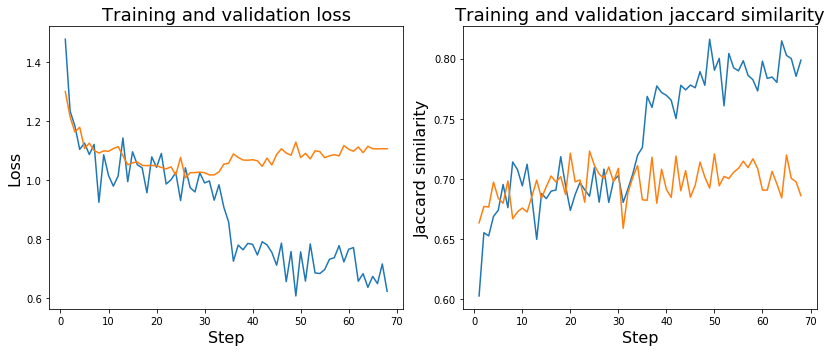

In [40]:
fig,axes=plt.subplots(1,2,figsize=(12,5))
axes[0].plot(step_df.step,step_df.Train_Loss,label="Training loss")
axes[0].plot(step_df.step,step_df.Val_Loss,label="Validation loss")
axes[0].set_xlabel("Step",fontsize=16)
axes[0].set_ylabel("Loss",fontsize=16)
axes[0].set_title("Training and validation loss",fontsize=18)

axes[1].plot(step_df.step,step_df.Train_jaccard_sim,label="Training jaccard similarity")
axes[1].plot(step_df.step,step_df.Val_jaccard_sim,label="Validation jaccard similarity")
axes[1].set_xlabel("Step",fontsize=16)
axes[1].set_ylabel("Jaccard similarity",fontsize=16)
axes[1].set_title("Training and validation jaccard similarity",fontsize=18)
plt.tight_layout()

<a id='Part3_link'></a>
# 3. Model evaluation

<a id='Part3.1_link'></a>
## 3.1 Predict extracted text using trained model for training datasets

In [41]:
def _get_best_indexes(logits, n_best_size):
    """Get the n-best logits from a list."""
    index_and_score = sorted(enumerate(logits), key=lambda x: x[1], reverse=True)
    best_indexes = []
    for i in range(len(index_and_score)):
        if i >= n_best_size:
            break
        best_indexes.append(index_and_score[i][0])
   
    return best_indexes

In [42]:
def _compute_softmax(scores):
    """Compute softmax probability over raw logits."""
    if not scores:
        return []

    max_score = None
    for score in scores:
        if max_score is None or score > max_score:
            max_score = score

    exp_scores = []
    total_sum = 0.0
    for score in scores:
        x = math.exp(score - max_score)
        exp_scores.append(x)
        total_sum += x

    probs = []
    for score in exp_scores:
        probs.append(score / total_sum)
    return probs

In [43]:
def get_final_text(pred_text, orig_text, do_lower_case, verbose_logging=False):
    """Project the tokenized prediction back to the original text."""

    def _strip_spaces(text):
        ns_chars = []
        ns_to_s_map = collections.OrderedDict()
        for (i, c) in enumerate(text):
            if c == " ":
                continue
            ns_to_s_map[len(ns_chars)] = i
            ns_chars.append(c)
        ns_text = "".join(ns_chars)
        return (ns_text, ns_to_s_map)

    
    tokenizer = BasicTokenizer(do_lower_case=do_lower_case)

    tok_text = " ".join(tokenizer.tokenize(orig_text))

    start_position = tok_text.find(pred_text)
    if start_position == -1:
        if verbose_logging:
            logger.info(
                "Unable to find text: '%s' in '%s'" % (pred_text, orig_text))
        return orig_text
    end_position = start_position + len(pred_text) - 1

    (orig_ns_text, orig_ns_to_s_map) = _strip_spaces(orig_text)
    (tok_ns_text, tok_ns_to_s_map) = _strip_spaces(tok_text)

    if len(orig_ns_text) != len(tok_ns_text):
        if verbose_logging:
            logger.info("Length not equal after stripping spaces: '%s' vs '%s'",
                        orig_ns_text, tok_ns_text)
        return orig_text

    # We then project the characters in `pred_text` back to `orig_text` using
    # the character-to-character alignment.
    tok_s_to_ns_map = {}
    for (i, tok_index) in tok_ns_to_s_map.items():
        tok_s_to_ns_map[tok_index] = i

    orig_start_position = None
    if start_position in tok_s_to_ns_map:
        ns_start_position = tok_s_to_ns_map[start_position]
        if ns_start_position in orig_ns_to_s_map:
            orig_start_position = orig_ns_to_s_map[ns_start_position]

    if orig_start_position is None:
        if verbose_logging:
            logger.info("Couldn't map start position")
        return orig_text

    orig_end_position = None
    if end_position in tok_s_to_ns_map:
        ns_end_position = tok_s_to_ns_map[end_position]
        if ns_end_position in orig_ns_to_s_map:
            orig_end_position = orig_ns_to_s_map[ns_end_position]

    if orig_end_position is None:
        if verbose_logging:
            logger.info("Couldn't map end position")
        return orig_text

    output_text = orig_text[orig_start_position:(orig_end_position + 1)]
    return output_text

In [44]:
def bert_qa_pred(feature,example,model,n_best_size,max_answer_length):
    
    test_input_ids,test_token_type_ids,test_attention_masks,test_start_positions,test_end_positions=bert_qa_input([feature])
    with torch.no_grad():
        model.eval()
        start_scores,end_scores=model(test_input_ids,
                                      token_type_ids=test_token_type_ids,
                                      attention_mask=test_attention_masks)    
    
    prelim_predictions = []
    start_indexes=_get_best_indexes(start_scores.squeeze(),10)
    end_indexes=_get_best_indexes(end_scores.squeeze(),10)

    _PrelimPrediction = collections.namedtuple(  # pylint: disable=invalid-name
        "PrelimPrediction",["example_index", "start_index", "end_index", "start_logit", "end_logit"])

    for start_index in start_indexes:
        for end_index in end_indexes:
            #### we remove the indexes which are invalid @
            if start_index >= len(feature.tokens):
                continue
            if end_index >= len(feature.tokens):
                continue
            if start_index not in feature.token_to_orig_map:
                continue
            if end_index not in feature.token_to_orig_map:
                continue
            if not feature.token_is_max_context.get(start_index, False):
                continue
            if end_index < start_index:
                continue
            length = end_index - start_index + 1
            if length > max_answer_length:
                continue

            prelim_predictions.append(
                _PrelimPrediction(
                    example_index=feature.example_index,
                    start_index=start_index,
                    end_index=end_index,
                    start_logit=start_scores.squeeze()[start_index],
                    end_logit=end_scores.squeeze()[end_index]))

    prelim_predictions = sorted(
        prelim_predictions,
        key=lambda x: (x.start_logit + x.end_logit),
        reverse=True)
    
    
    _NbestPrediction = collections.namedtuple(  # pylint: disable=invalid-name
    "NbestPrediction", ["text", "start_logit", "end_logit"])

    seen_predictions = {}
    nbest = []
    for pred in prelim_predictions:
        if len(nbest) >= n_best_size:
            break
    
        if pred.start_index > 0:
            tok_tokens = feature.tokens[pred.start_index:(pred.end_index + 1)]
            orig_doc_start = feature.token_to_orig_map[pred.start_index]
            orig_doc_end = feature.token_to_orig_map[pred.end_index]
            orig_tokens = example.doc_tokens[orig_doc_start:(orig_doc_end + 1)]
            tok_text = tokenizer.convert_tokens_to_string(tok_tokens)
    
            # Clean whitespace
            tok_text = tok_text.strip()
            tok_text = " ".join(tok_text.split())
            orig_text = " ".join(orig_tokens)
            
            final_text = get_final_text(tok_text, orig_text, True)
            if final_text in seen_predictions:
                continue
            
            seen_predictions[final_text] = True
        else:
            final_text = ""
            seen_predictions[final_text] = True
    
        nbest.append(_NbestPrediction(
            text=final_text,
            start_logit=pred.start_logit,
            end_logit=pred.end_logit))

    if not nbest:
        nbest.append(_NbestPrediction(text="empty", start_logit=0.0, end_logit=0.0))
    assert len(nbest) >= 1
    
    
    total_scores = []
    best_non_null_entry = None
    for entry in nbest:
        total_scores.append(entry.start_logit + entry.end_logit)
        if not best_non_null_entry:
            if entry.text:
                best_non_null_entry = entry
    probs = _compute_softmax(total_scores)
    nbest_json = []
    for (i, entry) in enumerate(nbest):
        output = collections.OrderedDict()
        output["text"] = entry.text
        output["probability"] = probs[i]
        output["start_logit"] = entry.start_logit.item()
        output["end_logit"] = entry.end_logit.item()
        nbest_json.append(output)
    
    assert len(nbest_json) >= 1
    all_predictions[feature.example_index].append(nbest_json[0]["text"])
    all_predictions[feature.example_index].append(nbest_json[0]["probability"])
    pred_df=pd.DataFrame(nbest_json)
    
    return pred_df

In [51]:
model = BertForQuestionAnswering.from_pretrained(os.path.join(base_dir,"bert_qa_models/Tweet_bert_qa_maxlen128_epoch2_batch8_step80_clip1"))


In [52]:
train_examples=read_paragraphs(train_df,is_training=False)
train_features=convert_examples_to_features(train_examples,tokenizer,max_seq_length=128,doc_stride=1,max_query_length=10,is_training=False)


In [53]:
print(len(train_examples))
print(len(train_features))

27480
27480


In [317]:
all_predictions = collections.defaultdict(list)
for i in tqdm(range(len(train_features))):
    feature=train_features[i]
    example=train_examples[i]
    bert_qa_pred(feature,example,model,n_best_size=10,max_answer_length=64)

100%|██████████| 27480/27480 [6:43:32<00:00,  1.13it/s]  


In [318]:
preds_df=pd.DataFrame.from_dict(all_predictions,orient="index",columns=["bert_qa_predict","probability"])
preds_df.index.name="textID"
preds_df.reset_index(inplace=True)
preds_df=preds_df.merge(train_df,left_on="textID",right_on="textID")
print(preds_df.shape)
preds_df.head()

(27480, 6)


,textID,bert_qa_predict,probability,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going",0.984853,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,SAD,0.380390,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,bullying me...,0.301934,my boss is bullying me...,bullying me,negative
3,9642c003ef,leave me alone,0.680899,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****,",0.324223,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


<a id='Part3.2_link'></a>
## 3.2 Compute jaccard similarity score for predictions on training datasets

In [45]:
def compute_jaccard_similarity(sent1,sent2):
    sents1=sent_tokenize(str(sent1).lower().strip())
    sents2=sent_tokenize(str(sent2).lower().strip())
    a=set()
    for sent in sents1:
        tokens=sent.split()
        a=a.union(set(tokens))
    b=set()
    for sent in sents2:
        tokens=sent.split()
        b=b.union(set(tokens))
    return len(a.intersection(b))/len(a.union(b))

In [324]:
preds_df["bert_qa_jaccard"]=preds_df.apply(lambda x:compute_jaccard_similarity(x.bert_qa_predict,x.selected_text),axis=1)
preds_df.head()

,textID,bert_qa_predict,probability,text,selected_text,sentiment,bert_qa_jaccard
0,cb774db0d1,"I`d have responded, if I were going",0.984853,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000
1,549e992a42,SAD,0.380390,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.500000
2,088c60f138,bullying me...,0.301934,my boss is bullying me...,bullying me,negative,0.333333
3,9642c003ef,leave me alone,0.680899,what interview! leave me alone,leave me alone,negative,1.000000
4,358bd9e861,"Sons of ****,",0.324223,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,1.000000


In [327]:
preds_df.to_csv(os.path.join(base_dir,"bert_qa_models/train_bert_qa_predict.csv"),index=False)

In [47]:
preds_df=pd.read_csv(os.path.join(base_dir,"bert_qa_models/train_bert_qa_predict.csv"))

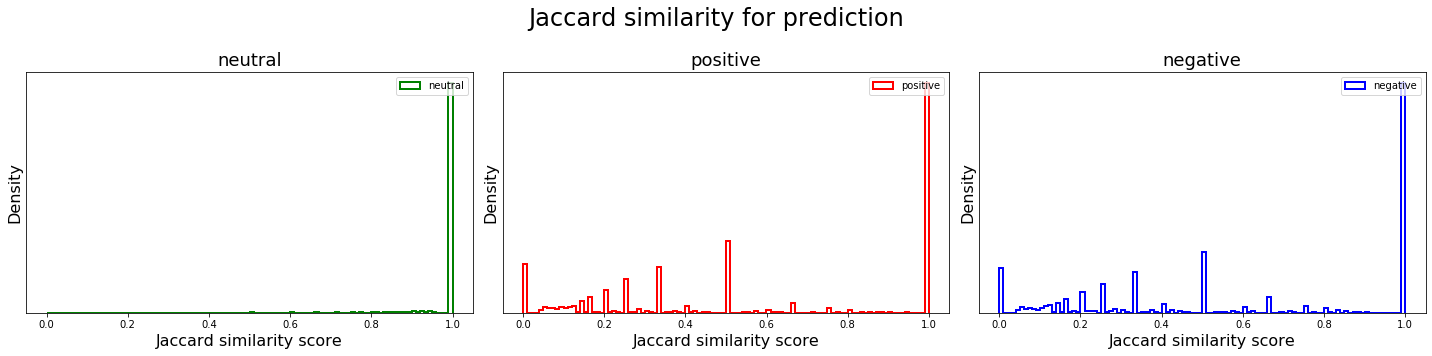

In [55]:
fig,axes=plt.subplots(1,3,figsize=(20,5))
sentiments=["neutral","positive","negative"]
colors=["green","red","blue"]
for i in range(3):
    sentiment=sentiments[i]
    axes[i].hist(preds_df[preds_df.sentiment==sentiment].bert_qa_jaccard,bins=100,histtype="step",color=colors[i],density=True,label=sentiment,linewidth=2)
    axes[i].set_xlabel("Jaccard similarity score",fontsize=16)
    axes[i].set_yticks([])
    axes[i].set_ylabel("Density",fontsize=16)
    axes[i].set_title(sentiment,fontsize=18)
    axes[i].legend()
fig.suptitle("Jaccard similarity for prediction",fontsize=24)
plt.tight_layout()
fig.subplots_adjust(top=0.8)

<a id='Part4_link'></a>
# 4. Prediction on test datasets

In [50]:
test_examples=read_paragraphs(test_df,is_training=False)
test_features=convert_examples_to_features(test_examples,tokenizer,max_seq_length=128,doc_stride=1,max_query_length=10,is_training=False)


In [226]:
model = BertForQuestionAnswering.from_pretrained(os.path.join(base_dir,"bert_qa_models/Tweet_bert_qa_maxlen128_epoch2_batch8_step80_clip1"))


In [283]:
all_predictions = collections.defaultdict(list)
for i in tqdm(range(len(test_features))):
    feature=test_features[i]
    example=test_examples[i]
    bert_qa_pred(feature,example,model,n_best_size=10,max_answer_length=64)

100%|██████████| 3534/3534 [48:58<00:00,  1.20it/s]


In [311]:
preds_df=pd.DataFrame.from_dict(all_predictions,orient="index",columns=["bert_qa_predict","probability"])
preds_df.index.name="textID"
preds_df.reset_index(inplace=True)

In [312]:
print(preds_df.shape)
preds_df.head()

(3534, 3)


,textID,bert_qa_predict,probability
0,f87dea47db,Last session of the day,0.509039
1,96d74cb729,Good,0.174342
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",0.360804
3,01082688c6,happy,0.502207
4,33987a8ee5,I like it!!,0.311933


In [313]:
preds_df=preds_df.merge(test_df,left_on="textID",right_on="textID")
print(preds_df.shape)
preds_df.head()

(3534, 5)


,textID,bert_qa_predict,probability,text,sentiment
0,f87dea47db,Last session of the day,0.509039,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Good,0.174342,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",0.360804,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy,0.502207,happy bday!,positive
4,33987a8ee5,I like it!!,0.311933,http://twitpic.com/4w75p - I like it!!,positive


In [314]:
preds_df.to_csv(os.path.join(base_dir,"bert_qa_models/test_bert_qa_predict.csv"),index=False)

In [310]:
preds_df2=preds_df.loc[:,["textID","bert_qa_predict"]].rename(columns={"bert_qa_predict":"selected_text"})
#preds_df2.head()
preds_df2.to_csv(os.path.join(base_dir,"bert_qa_models/submission2.csv"),index=False)